### Analyze Blind Experiment 4

- 08-30-22
- Joel Stremmel

##### About

This notebook reads the output from the 4th blind experiment and computes performance measures for the various algorithms tested for clinician reviewer #1 and #2.

##### Imports

In [1]:
# Open imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats.stats import ttest_ind
from scipy.stats import median_test, pearsonr

# Project import (for colorblind friendly plotting)
import project_configs

##### Set Run Parameters

In [2]:
K_MAX = 5
NUM_BOOTSTRAP = 1000
SX, SY, SL, SA = 3, 3, 5, 6.5
BASE_PATH = "../results/masking/"
GLOBAL_ALL_INFO_INPATH = "../results/masking/exp4_global_dfs/global_all_info.csv"
R1_GLOBAL_EXP_DATA_INPATH = "../results/masking/exp4_global_dfs/r1_results.csv"
R2_GLOBAL_EXP_DATA_INPATH = "../results/masking/exp4_global_dfs/r2_results.csv"

##### Load Dataframe of All Algorithm Information 
This dataframe includes information hidden during the blind experiment.

In [3]:
all_info_df = pd.read_csv(GLOBAL_ALL_INFO_INPATH)

##### Load and Combine Data from Reviewer # 1

In [4]:
r1_exp_data_df = pd.read_csv(R1_GLOBAL_EXP_DATA_INPATH)
r1_combined_df = pd.merge(
    all_info_df,
    r1_exp_data_df.drop(["icd_code", "icd_description", "text_block"], axis=1),
    on="global_row_id",
    how="inner",
)
print(r1_combined_df.shape)

(1200, 15)


##### Load and Combine Data from Reviewer # 2

In [5]:
r2_exp_data_df = pd.read_csv(R2_GLOBAL_EXP_DATA_INPATH)
r2_exp_data_df["informative_0_or_1"] = r2_exp_data_df["informative_0_or_1"].fillna(0)
r2_combined_df = pd.merge(
    all_info_df,
    r2_exp_data_df.drop(["icd_code", "icd_description", "text_block"], axis=1),
    on="global_row_id",
    how="inner",
)
print(r2_combined_df.shape)

(1200, 15)


##### Count Total Records for each Method

In [6]:
for i, df in enumerate([r1_combined_df, r2_combined_df]):
    print(f"Reviewer #{i + 1} data:")
    print(df[df["P"] == "RANDOM"].shape)
    print(df[df["P"] == "SOC"].shape)
    print(df[df["P"] == "0.1"].shape)

Reviewer #1 data:
(400, 15)
(400, 15)
(400, 15)
Reviewer #2 data:
(400, 15)
(400, 15)
(400, 15)


##### Define Function to Normalize Scores

In [7]:
def norm(col, how=None):
    """Min max scale."""

    if how == "minmax":

        return (col - col.min()) / (col.max() - col.min())

    elif how == "maxabs":

        return col / col.abs().max()

    elif how == "standard":

        return (col - col.mean()) / col.std()

    elif how == None:

        return col

    else:

        raise ValueError(
            f"Expected how to be one of ['minmax', 'maxabs', 'standard', None] but got: {how}."
        )

##### Define Function to Plot and Print Block Scores

In [8]:
def plot_and_print(df, algo):

    assert algo in [
        "0.1",
        "SOC",
    ], f"Expected algo to be one of ['0.1', 'SOC'] but got: {algo}."

    med = df[df["P"] == algo]["normed_avg_score_diff"].median()
    med0 = df[(df["P"] == algo) & (df["informative_0_or_1"] == 0)][
        "normed_avg_score_diff"
    ].median()
    med1 = df[(df["P"] == algo) & (df["informative_0_or_1"] == 1)][
        "normed_avg_score_diff"
    ].median()

    scores0 = df[(df["P"] == algo) & (df["informative_0_or_1"] == 0)][
        "normed_avg_score_diff"
    ]
    samples0 = range(len(scores0))
    scores1 = df[(df["P"] == algo) & (df["informative_0_or_1"] == 1)][
        "normed_avg_score_diff"
    ]
    samples1 = range(len(scores1))

    print(
        f"Algo {algo} was applied to {len(samples0)} uninformative, {len(samples1)} informative, and {len(samples0) + len(samples1)} total text blocks."
    )
    print(f"Algo {algo} Median importance: {round(med, 5)}.")
    print(f"Algo {algo} Median importance of uninformative blocks: {round(med0, 5)}.")
    print(f"Algo {algo} Median importance of informative blocks: {round(med1, 5)}.")

    ttest_p = median_test(scores0, scores1)[1]
    print(
        f"P-Val of Mood's Median Test Comparing Importance Scores of Uninformative and Informative Blocks: {round(ttest_p, 5)}"
    )

    plt.figure(figsize=(10, 10))
    plt.scatter(
        samples0, scores0, label="Uninformative Block Importances", color="blue"
    )
    plt.scatter(
        samples1, scores1, label="Informative Block Importances", color="orange"
    )
    plt.axhline(y=med, color="red", linestyle="--", label="Median Block Importance")
    plt.axhline(
        y=med0,
        color="blue",
        linestyle="--",
        label="Median Uninformative Block Importance",
    )
    plt.axhline(
        y=med1,
        color="orange",
        linestyle="--",
        label="Median Informative Block Importance",
    )
    plt.legend(loc="best")
    plt.ylabel("Block Importance")
    plt.show()

##### Define Function to Plot Histograms

In [9]:
def plot_histograms(names, all_scores):

    plt.clf()
    bins = np.linspace(-0.5, 1, 20)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 6)
    axs = axs.ravel()

    for i, ax in enumerate(axs):

        for name, scores in zip(names[i], all_scores[i]):
            ax.hist(scores, bins, alpha=0.4, label=name)

        ax.legend(loc=0)
        ax.set_title("Score Distribution")
        ax.set_xlabel("Score")
        ax.set_ylabel("Frequency")

    plt.show()

##### Define Function to Plot and Print Distribution Information for SOC and MSP

In [10]:
def plot_and_print_normed_scatters_and_hists(df):

    both_df = df.copy()
    soc_df = df.copy()
    msp_df = df.copy()

    both_df["normed_avg_score_diff"] = norm(both_df["avg_score_diff"])
    soc_df["normed_avg_score_diff"] = norm(soc_df["avg_score_diff"])
    msp_df["normed_avg_score_diff"] = norm(msp_df["avg_score_diff"])

    plot_and_print(soc_df, algo="SOC")
    plot_and_print(msp_df, algo="0.1")

    # View split histograms
    names = [
        ["SOC Uninformative", "SOC Informative"],
        ["MSP Uninformative", "MSP Informative"],
    ]
    all_scores = [
        [
            soc_df[(soc_df["P"] == "SOC") & (soc_df["informative_0_or_1"] == 0)][
                "normed_avg_score_diff"
            ].tolist(),
            soc_df[(soc_df["P"] == "SOC") & (soc_df["informative_0_or_1"] == 1)][
                "normed_avg_score_diff"
            ].tolist(),
        ],
        [
            msp_df[(msp_df["P"] == "0.1") & (msp_df["informative_0_or_1"] == 0)][
                "normed_avg_score_diff"
            ].tolist(),
            msp_df[(msp_df["P"] == "0.1") & (msp_df["informative_0_or_1"] == 1)][
                "normed_avg_score_diff"
            ].tolist(),
        ],
    ]
    plot_histograms(names=names, all_scores=all_scores)

    # View combined histograms
    names = [
        ["SOC Uninformative", "MSP Uninformative"],
        ["SOC Informative", "MSP Informative"],
    ]
    all_scores = [
        [
            soc_df[(soc_df["P"] == "SOC") & (soc_df["informative_0_or_1"] == 0)][
                "normed_avg_score_diff"
            ].tolist(),
            msp_df[(msp_df["P"] == "0.1") & (msp_df["informative_0_or_1"] == 0)][
                "normed_avg_score_diff"
            ].tolist(),
        ],
        [
            soc_df[(soc_df["P"] == "SOC") & (soc_df["informative_0_or_1"] == 1)][
                "normed_avg_score_diff"
            ].tolist(),
            msp_df[(msp_df["P"] == "0.1") & (msp_df["informative_0_or_1"] == 1)][
                "normed_avg_score_diff"
            ].tolist(),
        ],
    ]
    plot_histograms(names=names, all_scores=all_scores)

##### View SOC and MSP Score Distributions According to Reviewer #1 Informativeness Scores

Algo SOC was applied to 359 uninformative, 41 informative, and 400 total text blocks.
Algo SOC Median importance: 0.1197.
Algo SOC Median importance of uninformative blocks: 0.11159.
Algo SOC Median importance of informative blocks: 0.21984.
P-Val of Mood's Median Test Comparing Importance Scores of Uninformative and Informative Blocks: 0.18723


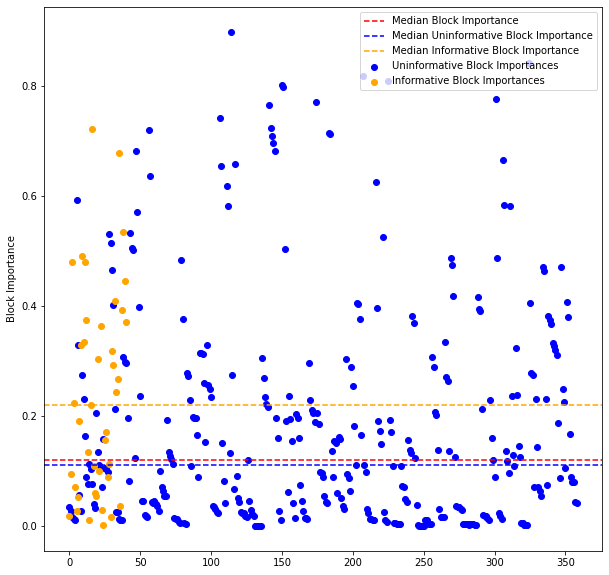

Algo 0.1 was applied to 328 uninformative, 72 informative, and 400 total text blocks.
Algo 0.1 Median importance: 0.08314.
Algo 0.1 Median importance of uninformative blocks: 0.07482.
Algo 0.1 Median importance of informative blocks: 0.16987.
P-Val of Mood's Median Test Comparing Importance Scores of Uninformative and Informative Blocks: 0.02693


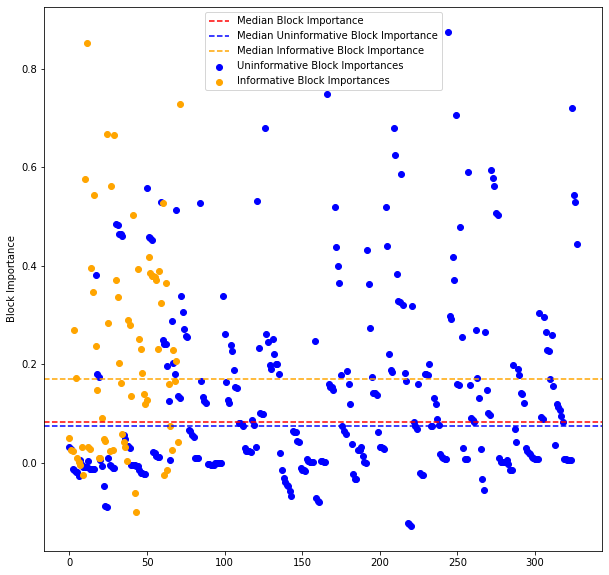

<Figure size 432x288 with 0 Axes>

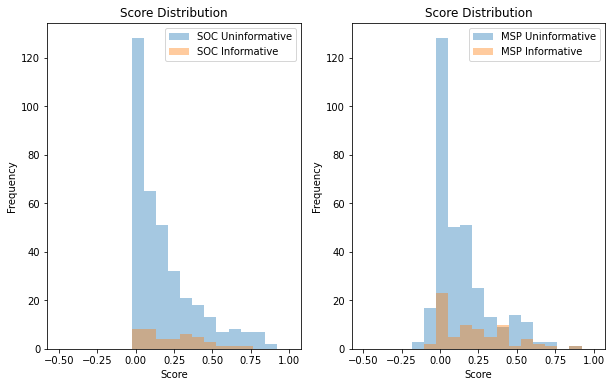

<Figure size 432x288 with 0 Axes>

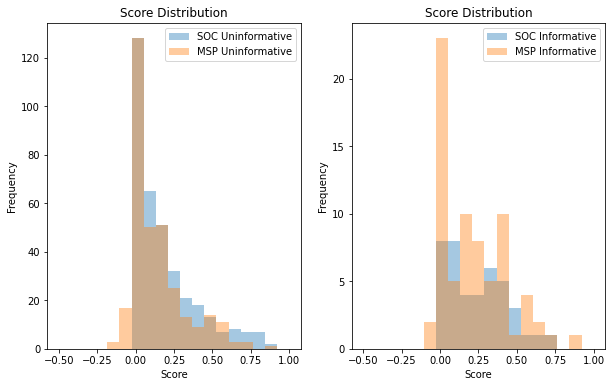

In [11]:
plot_and_print_normed_scatters_and_hists(r1_combined_df)

##### View SOC and MSP Score Distributions According to Reviewer #2 Informativeness Scores

Algo SOC was applied to 355 uninformative, 45 informative, and 400 total text blocks.
Algo SOC Median importance: 0.1197.
Algo SOC Median importance of uninformative blocks: 0.10891.
Algo SOC Median importance of informative blocks: 0.22307.
P-Val of Mood's Median Test Comparing Importance Scores of Uninformative and Informative Blocks: 0.01135


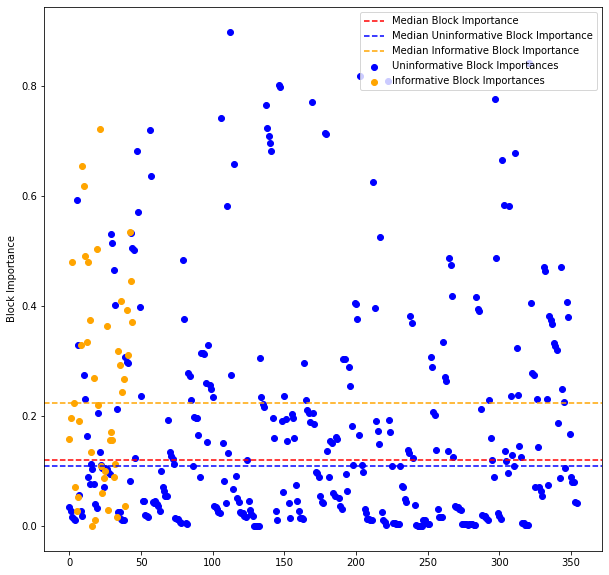

Algo 0.1 was applied to 325 uninformative, 75 informative, and 400 total text blocks.
Algo 0.1 Median importance: 0.08314.
Algo 0.1 Median importance of uninformative blocks: 0.07422.
Algo 0.1 Median importance of informative blocks: 0.17252.
P-Val of Mood's Median Test Comparing Importance Scores of Uninformative and Informative Blocks: 0.01041


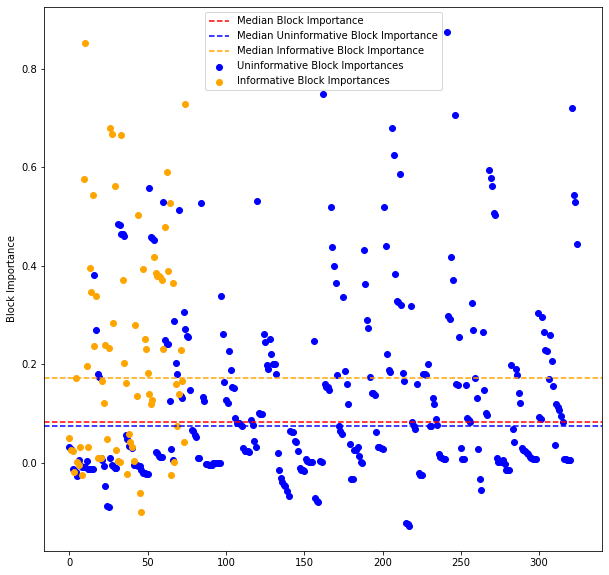

<Figure size 432x288 with 0 Axes>

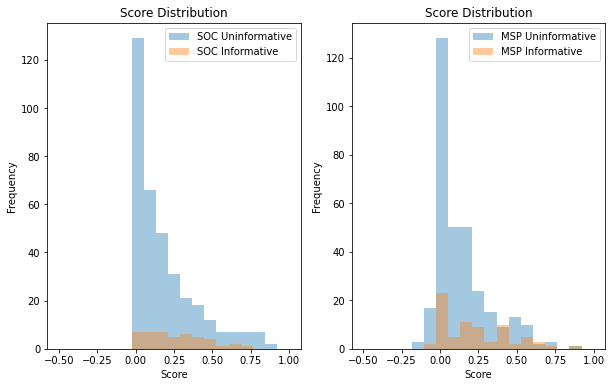

<Figure size 432x288 with 0 Axes>

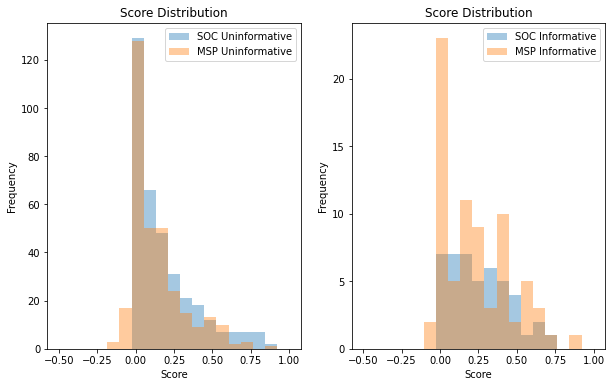

In [12]:
plot_and_print_normed_scatters_and_hists(r2_combined_df)

##### Define Function to Compute Fixed Count Statistics

In [13]:
def compute_fixed_count_stats(df):
    """
    Compute fixed statistics on dataframe of counts
    """

    counts = []
    proportions = []
    random_ps = []
    soc_ps = []
    for p in df.columns:

        counts.append(df[p].sum())
        proportions.append(round(df[p].mean(), 5))
        random_ps.append(round(ttest_ind(df[p], df["RANDOM"], equal_var=False)[1], 5))
        soc_ps.append(round(ttest_ind(df[p], df["SOC"], equal_var=False)[1], 5))

    df = pd.DataFrame(
        {
            "Model": df.columns,
            "Count of Informative Text Blocks": counts,
            "Proportion of Informative Text Blocks": proportions,
            "Comparison to Random - P-Value": random_ps,
            "Comparison to SOC - P-Value": soc_ps,
        }
    )

    return df

##### Define Function to Group and Count Informative Blocks by Algorithm

In [14]:
def group_and_count(df):

    grouped_results = (
        df[["P", "informative_0_or_1"]]
        .groupby("P")
        .sum("informative_0_or_1")
        .reset_index()
    )
    p_dict = {
        p: df[df["P"] == p]["informative_0_or_1"].tolist()
        for p in grouped_results["P"].tolist()
    }

    return pd.DataFrame(p_dict)

##### Group and Count Reviewer #1 Informative Blocks by Algorithm

In [15]:
r1_stats_df = group_and_count(r1_combined_df)
r1_count_stats = compute_fixed_count_stats(r1_stats_df)
r1_count_stats

,Model,Count of Informative Text Blocks,Proportion of Informative Text Blocks,Comparison to Random - P-Value,Comparison to SOC - P-Value
0,0.1,72,0.1800,0.0,0.00163
1,RANDOM,7,0.0175,1.0,0.00000
2,SOC,41,0.1025,0.0,1.00000


##### Group and Count Reviewer #2 Informative Blocks by Algorithm

In [16]:
r2_stats_df = group_and_count(r2_combined_df)
r2_count_stats = compute_fixed_count_stats(r2_stats_df)
r2_count_stats

,Model,Count of Informative Text Blocks,Proportion of Informative Text Blocks,Comparison to Random - P-Value,Comparison to SOC - P-Value
0,0.1,75.0,0.1875,0.0,0.00294
1,RANDOM,10.0,0.0250,1.0,0.00000
2,SOC,45.0,0.1125,0.0,1.00000


##### Define Function to Compute Top K Performance Measures

In [17]:
def compute_top_k(df, k_max, num_bootstrap):

    # Define data to collect over iterations
    data = {
        "msp_mrr_means": [],
        "msp_mrr_ci_lows": [],
        "msp_mrr_ci_highs": [],
        "soc_mrr_means": [],
        "soc_mrr_ci_lows": [],
        "soc_mrr_ci_highs": [],
        "soc_mrr_ci_highs": [],
        "rnd_mrr_means": [],
        "rnd_mrr_ci_lows": [],
        "rnd_mrr_ci_highs": [],
        "msp_p_means": [],
        "msp_p_ci_lows": [],
        "msp_p_ci_highs": [],
        "soc_p_means": [],
        "soc_p_ci_lows": [],
        "soc_p_ci_highs": [],
        "rnd_p_means": [],
        "rnd_p_ci_lows": [],
        "rnd_p_ci_highs": [],
        "msp_h_means": [],
        "msp_h_ci_lows": [],
        "msp_h_ci_highs": [],
        "soc_h_means": [],
        "soc_h_ci_lows": [],
        "soc_h_ci_highs": [],
        "rnd_h_means": [],
        "rnd_h_ci_lows": [],
        "rnd_h_ci_highs": [],
    }

    # Iterate through multiple ks
    ks = list(range(1, k_max + 1, 1))
    for k in ks:

        # Group data by label, doc, algorithm combinations and compute number of
        # lists of suggested explanations for each explanation and a list of list ids
        df["list_id"] = df.groupby(["icd_code", "sample", "P"]).ngroup()
        num_lists = df["list_id"].nunique()
        all_list_ids = list(set(df["list_id"].tolist()))

        # Run bootstrap iterations to sample from list ids
        mrrs = {"MSP": [], "SOC": [], "RAN": []}
        ps = {"MSP": [], "SOC": [], "RAN": []}
        hs = {"MSP": [], "SOC": [], "RAN": []}
        for i in range(num_bootstrap):

            # Sample with replacement
            sampled_list_ids = np.random.choice(all_list_ids, num_lists, replace=True)
            sampled_df = df[df["list_id"].isin(sampled_list_ids)]

            # Get top k most important blocks for each label, doc, algorithm combination
            topk_plus_df = (
                sampled_df.groupby(["list_id"])["avg_score_diff"]
                .apply(lambda grp: grp.nlargest(k))
                .reset_index()
            )

            # Get all info for top k selected
            topk_df = pd.merge(
                topk_plus_df.drop("level_1", axis=1),
                sampled_df,
                how="inner",
                on=["list_id", "avg_score_diff"],
            )

            # Compute ranks within each group of labels, docs, and algorithms according to avg_score_diff
            topk_df["rank"] = topk_df.groupby(["list_id"])["avg_score_diff"].rank(
                "dense", ascending=False
            )

            # Take the reciprocal ranking for informative samples and set to 0 otherwise
            topk_df["mrr_weight"] = topk_df["informative_0_or_1"] / topk_df["rank"]

            # Get the highest reciprocal ranking per group
            mrr_max_df = (
                topk_df[["icd_code", "sample", "P", "mrr_weight"]]
                .groupby(["icd_code", "sample", "P"])
                .max("mrr_weight")
                .reset_index()
            )

            # Compute the mean reciprocal ranking over all groups
            mrr_df = (
                mrr_max_df[["P", "mrr_weight"]]
                .groupby("P")
                .mean("mrr_weight")
                .reset_index()
            )

            # Save MRRs
            mrrs["MSP"].append(mrr_df[mrr_df["P"] == "0.1"]["mrr_weight"].iloc[0])
            mrrs["SOC"].append(mrr_df[mrr_df["P"] == "SOC"]["mrr_weight"].iloc[0])
            mrrs["RAN"].append(mrr_df[mrr_df["P"] == "RANDOM"]["mrr_weight"].iloc[0])

            # Count informative blocks per label, doc, algo group
            sum_df = (
                topk_df[["icd_code", "sample", "P", "informative_0_or_1"]]
                .groupby(["icd_code", "sample", "P"])
                .sum("informative_0_or_1")
                .reset_index()
            )

            # Compute P@ks
            sum_df["precision"] = sum_df["informative_0_or_1"] / k

            # Compute precision and recall over all groups
            p_df = (
                sum_df[["P", "precision"]].groupby("P").mean("precision").reset_index()
            )

            # Save P@ks
            ps["MSP"].append(p_df[p_df["P"] == "0.1"]["precision"].iloc[0])
            ps["SOC"].append(p_df[p_df["P"] == "SOC"]["precision"].iloc[0])
            ps["RAN"].append(p_df[p_df["P"] == "RANDOM"]["precision"].iloc[0])

            # Compute hits
            sum_df["hit"] = sum_df["informative_0_or_1"].apply(
                lambda x: 1 if x >= 1 else 0
            )

            # Compute hits over all groups
            h_df = sum_df[["P", "hit"]].groupby("P").mean("hit").reset_index()

            # Save H@ks
            hs["MSP"].append(h_df[h_df["P"] == "0.1"]["hit"].iloc[0])
            hs["SOC"].append(h_df[h_df["P"] == "SOC"]["hit"].iloc[0])
            hs["RAN"].append(h_df[h_df["P"] == "RANDOM"]["hit"].iloc[0])

        # Compute means and CIs from boostrap iterations for MRR
        data["msp_mrr_means"].append(np.mean(mrrs["MSP"]))
        data["msp_mrr_ci_lows"].append(
            np.mean(mrrs["MSP"]) - 1.96 * np.std(mrrs["MSP"])
        )
        data["msp_mrr_ci_highs"].append(
            np.mean(mrrs["MSP"]) + 1.96 * np.std(mrrs["MSP"])
        )

        data["soc_mrr_means"].append(np.mean(mrrs["SOC"]))
        data["soc_mrr_ci_lows"].append(
            np.mean(mrrs["SOC"]) - 1.96 * np.std(mrrs["SOC"])
        )
        data["soc_mrr_ci_highs"].append(
            np.mean(mrrs["SOC"]) + 1.96 * np.std(mrrs["SOC"])
        )

        data["rnd_mrr_means"].append(np.mean(mrrs["RAN"]))
        data["rnd_mrr_ci_lows"].append(
            np.mean(mrrs["RAN"]) - 1.96 * np.std(mrrs["RAN"])
        )
        data["rnd_mrr_ci_highs"].append(
            np.mean(mrrs["RAN"]) + 1.96 * np.std(mrrs["RAN"])
        )

        # Compute means and CIs from boostrap iterations for P@ks
        data["msp_p_means"].append(np.mean(ps["MSP"]))
        data["msp_p_ci_lows"].append(np.mean(ps["MSP"]) - 1.96 * np.std(ps["MSP"]))
        data["msp_p_ci_highs"].append(np.mean(ps["MSP"]) + 1.96 * np.std(ps["MSP"]))

        data["soc_p_means"].append(np.mean(ps["SOC"]))
        data["soc_p_ci_lows"].append(np.mean(ps["SOC"]) - 1.96 * np.std(ps["SOC"]))
        data["soc_p_ci_highs"].append(np.mean(ps["SOC"]) + 1.96 * np.std(ps["SOC"]))

        data["rnd_p_means"].append(np.mean(ps["RAN"]))
        data["rnd_p_ci_lows"].append(np.mean(ps["RAN"]) - 1.96 * np.std(ps["RAN"]))
        data["rnd_p_ci_highs"].append(np.mean(ps["RAN"]) + 1.96 * np.std(ps["RAN"]))

        # Compute means and CIs from boostrap iterations for H@ks
        data["msp_h_means"].append(np.mean(hs["MSP"]))
        data["msp_h_ci_lows"].append(np.mean(hs["MSP"]) - 1.96 * np.std(hs["MSP"]))
        data["msp_h_ci_highs"].append(np.mean(hs["MSP"]) + 1.96 * np.std(hs["MSP"]))

        data["soc_h_means"].append(np.mean(hs["SOC"]))
        data["soc_h_ci_lows"].append(np.mean(hs["SOC"]) - 1.96 * np.std(hs["SOC"]))
        data["soc_h_ci_highs"].append(np.mean(hs["SOC"]) + 1.96 * np.std(hs["SOC"]))

        data["rnd_h_means"].append(np.mean(hs["RAN"]))
        data["rnd_h_ci_lows"].append(np.mean(hs["RAN"]) - 1.96 * np.std(hs["RAN"]))
        data["rnd_h_ci_highs"].append(np.mean(hs["RAN"]) + 1.96 * np.std(hs["RAN"]))

    return ks, data

##### Compute Top K Performance Measures

In [18]:
r1_ks, r1_data = compute_top_k(df=r1_combined_df, k_max=K_MAX, num_bootstrap=NUM_BOOTSTRAP)
r2_ks, r2_data = compute_top_k(df=r2_combined_df, k_max=K_MAX, num_bootstrap=NUM_BOOTSTRAP)

##### Define Scatter with CI Plotting Function

In [19]:
def plot_scatter_cis(ax, xs, ys, ci_lows, ci_highs, color, label, offset, marker):

    x_adj = np.array(xs) + offset
    ax.plot(x_adj, ys, color=color)
    ax.scatter(x_adj, ys, color=color, marker=marker, label=label)
    ax.fill_between(x_adj, ci_lows, ci_highs, color=color, alpha=0.3)

##### Plot Mean Reciprocal Ranking at K

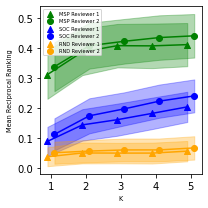

In [20]:
fig, ax = plt.subplots(figsize=(SX, SY))

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["msp_mrr_means"],
    ci_lows=r1_data["msp_mrr_ci_lows"],
    ci_highs=r1_data["msp_mrr_ci_highs"],
    color="green",
    label="MSP Reviewer 1",
    offset=-0.1,
    marker="^",
)
plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["msp_mrr_means"],
    ci_lows=r2_data["msp_mrr_ci_lows"],
    ci_highs=r2_data["msp_mrr_ci_highs"],
    color="green",
    label="MSP Reviewer 2",
    offset=0.1,
    marker="o",
)

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["soc_mrr_means"],
    ci_lows=r1_data["soc_mrr_ci_lows"],
    ci_highs=r1_data["soc_mrr_ci_highs"],
    color="blue",
    label="SOC Reviewer 1",
    offset=-0.1,
    marker="^",
)
plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["soc_mrr_means"],
    ci_lows=r2_data["soc_mrr_ci_lows"],
    ci_highs=r2_data["soc_mrr_ci_highs"],
    color="blue",
    label="SOC Reviewer 2",
    offset=0.1,
    marker="o",
)

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["rnd_mrr_means"],
    ci_lows=r1_data["rnd_mrr_ci_lows"],
    ci_highs=r1_data["rnd_mrr_ci_highs"],
    color="orange",
    label="RND Reviewer 1",
    offset=-0.1,
    marker="^",
)

plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["rnd_mrr_means"],
    ci_lows=r2_data["rnd_mrr_ci_lows"],
    ci_highs=r2_data["rnd_mrr_ci_highs"],
    color="orange",
    label="RND Reviewer 2",
    offset=0.1,
    marker="o",
)

ax.legend(loc="upper left", prop={'size': SL})
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel("Mean Reciprocal Ranking", fontsize=SA)
plt.xlabel("K", fontsize=SA)
plt.tight_layout()
plt.savefig("../figures/exp4_mrrs_at_k.pdf", transparent=False)

##### Plot Precision at K

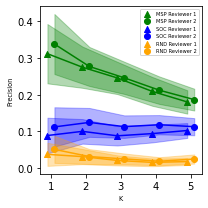

In [21]:
fig, ax = plt.subplots(figsize=(SX, SY))

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["msp_p_means"],
    ci_lows=r1_data["msp_p_ci_lows"],
    ci_highs=r1_data["msp_p_ci_highs"],
    color="green",
    label="MSP Reviewer 1",
    offset=-0.1,
    marker="^",
)
plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["msp_p_means"],
    ci_lows=r2_data["msp_p_ci_lows"],
    ci_highs=r2_data["msp_p_ci_highs"],
    color="green",
    label="MSP Reviewer 2",
    offset=0.1,
    marker="o",
)

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["soc_p_means"],
    ci_lows=r1_data["soc_p_ci_lows"],
    ci_highs=r1_data["soc_p_ci_highs"],
    color="blue",
    label="SOC Reviewer 1",
    offset=-0.1,
    marker="^",
)
plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["soc_p_means"],
    ci_lows=r2_data["soc_p_ci_lows"],
    ci_highs=r2_data["soc_p_ci_highs"],
    color="blue",
    label="SOC Reviewer 2",
    offset=0.1,
    marker="o",
)

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["rnd_p_means"],
    ci_lows=r1_data["rnd_p_ci_lows"],
    ci_highs=r1_data["rnd_p_ci_highs"],
    color="orange",
    label="RND Reviewer 1",
    offset=-0.1,
    marker="^",
)

plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["rnd_p_means"],
    ci_lows=r2_data["rnd_p_ci_lows"],
    ci_highs=r2_data["rnd_p_ci_highs"],
    color="orange",
    label="RND Reviewer 2",
    offset=0.1,
    marker="o",
)

ax.legend(loc="best", prop={'size': SL})
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel("Precision", fontsize=SA)
plt.xlabel("K", fontsize=SA)
plt.tight_layout()
plt.savefig("../figures/exp4_ps_at_k.pdf", transparent=False)

##### Plot Hits at K

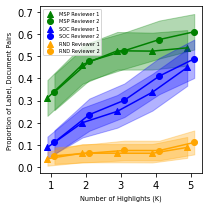

In [22]:
fig, ax = plt.subplots(figsize=(SX, SY))

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["msp_h_means"],
    ci_lows=r1_data["msp_h_ci_lows"],
    ci_highs=r1_data["msp_h_ci_highs"],
    color="green",
    label="MSP Reviewer 1",
    offset=-0.1,
    marker="^",
)
plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["msp_h_means"],
    ci_lows=r2_data["msp_h_ci_lows"],
    ci_highs=r2_data["msp_h_ci_highs"],
    color="green",
    label="MSP Reviewer 2",
    offset=0.1,
    marker="o",
)

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["soc_h_means"],
    ci_lows=r1_data["soc_h_ci_lows"],
    ci_highs=r1_data["soc_h_ci_highs"],
    color="blue",
    label="SOC Reviewer 1",
    offset=-0.1,
    marker="^",
)
plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["soc_h_means"],
    ci_lows=r2_data["soc_h_ci_lows"],
    ci_highs=r2_data["soc_h_ci_highs"],
    color="blue",
    label="SOC Reviewer 2",
    offset=0.1,
    marker="o",
)

plot_scatter_cis(
    ax=ax,
    xs=r1_ks,
    ys=r1_data["rnd_h_means"],
    ci_lows=r1_data["rnd_h_ci_lows"],
    ci_highs=r1_data["rnd_h_ci_highs"],
    color="orange",
    label="RND Reviewer 1",
    offset=-0.1,
    marker="^",
)

plot_scatter_cis(
    ax=ax,
    xs=r2_ks,
    ys=r2_data["rnd_h_means"],
    ci_lows=r2_data["rnd_h_ci_lows"],
    ci_highs=r2_data["rnd_h_ci_highs"],
    color="orange",
    label="RND Reviewer 2",
    offset=0.1,
    marker="o",
)

ax.legend(loc="best", prop={'size': SL})
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel("Proportion of Label, Document Pairs", fontsize=SA)
plt.xlabel("Number of Highlights (K)", fontsize=SA)
plt.tight_layout()
plt.savefig("../figures/exp4_hs_at_k.pdf", transparent=False)

##### Compute Pearson Correlation Coefficients

In [23]:
def compute_pearson(df):

    msp_x = df[df["P"] == "0.1"]["avg_score_diff"].tolist()
    msp_y = df[df["P"] == "0.1"]["informative_0_or_1"].tolist()
    coef, p = pearsonr(msp_x, msp_y)
    print(f"Pearson correlation coefficient and P-value: {coef} (P={p})")

    soc_x = df[df["P"] == "SOC"]["avg_score_diff"].tolist()
    soc_y = df[df["P"] == "SOC"]["informative_0_or_1"].tolist()
    coef, p = pearsonr(soc_x, soc_y)
    print(f"Pearson correlation coefficient and P-value: {coef} (P={p})")

    ran_x = df[df["P"] == "RANDOM"]["avg_score_diff"].tolist()
    ran_y = df[df["P"] == "RANDOM"]["informative_0_or_1"].tolist()
    coef, p = pearsonr(ran_x, ran_y)
    print(f"Pearson correlation coefficient and P-value: {coef} (P={p})")

In [24]:
compute_pearson(r1_combined_df)

Pearson correlation coefficient and P-value: 0.16378680072312718 (P=0.0010100459655690993)
Pearson correlation coefficient and P-value: 0.08093620044715101 (P=0.10602712948042088)
Pearson correlation coefficient and P-value: 0.003938822384286479 (P=0.9374062914500165)


In [25]:
compute_pearson(r2_combined_df)

Pearson correlation coefficient and P-value: 0.1922485542277959 (P=0.00010924280732681684)
Pearson correlation coefficient and P-value: 0.11814290306516745 (P=0.018091152716179476)
Pearson correlation coefficient and P-value: 0.008301045350528174 (P=0.8685471476699795)
